# 🇮🇹 Italian Vocabulary Recommender

This system recommends new Italian vocabulary tailored to a language learner’s target CEFR (Common European Framework of Reference for Languages) level and known vocabulary. It uses rule-based filtering combined with semantic similarity and a machine learning model to rank how “ready” the learner is to learn each word.

# 🧩 Key Components
| Component                              | Description                                                           |
| -------------------------------------- | --------------------------------------------------------------------- |
| `known_words.json`                     | Tracks words the user already knows                                   |
| `italian_cefr_vocab_with_freq_pos.csv` | Dataset of Italian words with CEFR level, frequency, and POS          |
| `cc.it.filtered.vec`                   | Pretrained FastText word embeddings for semantic similarity           |
| `learnability_log.json`                | Session-based log of accepted/rejected words with features and labels |
| `word_readiness_model.pkl`             | Trained logistic regression model to predict word readiness           |


In [1]:
# Data Loading and Saving
import pandas as pd 
# Computing vectors
import numpy as np 
# Loading the model
import joblib 
# Storing known words and keeping logs
import os, json 
# Creating plots
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Extracting semantic concepts from documents
from gensim.models import KeyedVectors
# Comparing text documents 
from sklearn.metrics.pairwise import cosine_similarity
# Counting the occurrences of items in a sequence
from collections import Counter

# Input Collection
Known words are loaded from a json file and user enters their target CEFR level (A1-C2). In the example below, only 3 words are loaded since duplicates are removed. 
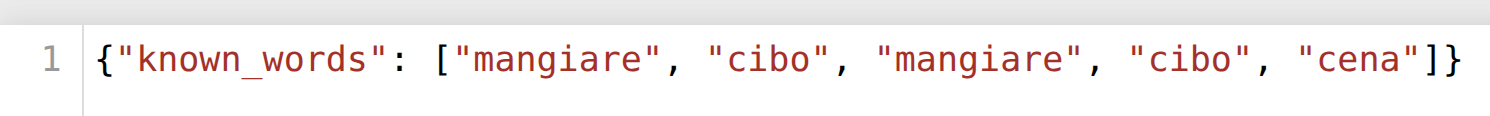

Known Words (loaded): {'mangiare', 'cena', 'cibo'}

In [3]:
# Automatically load known_words.json if available
known_words_path = "known_words.json"
if os.path.exists(known_words_path):
    with open(known_words_path, "r") as f:
        user_known_words = set(json.load(f)["known_words"])
    print(f"Loaded {len(user_known_words)} known words from known_words.json")
else:
    user_known_words = set()
    print("No existing known_words.json found. Starting with an empty known words list.")

Loaded 4 known words from known_words.json


In [4]:
# Prompt user for CEFR level (known words loaded automatically)
user_cefr_level = input("Enter your target CEFR level (A1, A2, B1, B2, C1, C2): ").strip().upper()
print(f"Known Words (loaded): {user_known_words}")

Enter your target CEFR level (A1, A2, B1, B2, C1, C2): B1
Known Words (loaded): {'cibo', 'cena', 'torta', 'mangiare'}


# Loading the vocabulary dataset 
Dataset of Italian words with CEFR level, frequency, and Part of Speech (POS) is loaded. The process of data extraction from a Frequency List is handled by Data Extraction.ipynb also stored in the repository. 
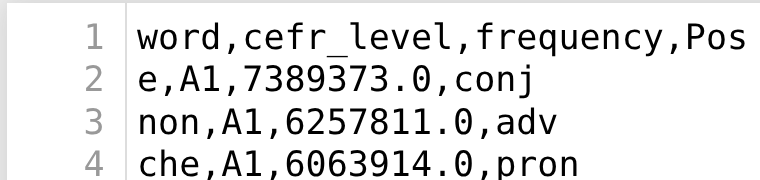

In [5]:
vocab_df = pd.read_csv("italian_cefr_vocab_with_freq_pos.csv")
vocab_df['word'] = vocab_df['word'].str.lower()

# Candidate Filtering
Filters vocabulary to:
    CEFR level ± 1 step (e.g. B1 → B1/B2)  
    Words not already known  
    Optionally filters to the most common POS among known words
    
## Advantage of recommending by dominant POS
It is a much more reliable strategy for ensuring that "mangiare" (a verb) returns similar words like "bere", "cucinare", "assaggiare", etc. It prevent unrelated word types (e.g., "felice", "lento") from appearing and it keeps recommendations grammatically relevant and easier to learn.

In [6]:
# Recommender function
def recommend_words(user_known_words, user_cefr_level, vocab_df, top_n=100):
    """
    Filters the vocabulary dataset according to CEFR level
    
    Args:
        user_known_words (set): unique words from known_words.json file
        user_cefr_level (str): user input 
        vocab_df (DataFrame): vocabulary dataset
        top_n (int): count of candidate words to return
    
    Returns:
        DataFrame of filtered vocabulary dataset
        user_pos (str): Dominant POS from known words
    """

    cefr_order = ["A1", "A2", "B1", "B2", "C1", "C2"]
    level_index = cefr_order.index(user_cefr_level)
    target_levels = cefr_order[max(0, level_index):min(len(cefr_order), level_index + 2)]
    
    print("user_known_words:", user_known_words)
    
    pos_tags = [
        row.iloc[0]['Pos']
        for word in user_known_words
        if not (row := vocab_df[vocab_df['word'] == word]).empty and 'Pos' in row.columns
    ]
    user_pos = Counter(pos_tags).most_common(1)[0][0] if pos_tags else None

    print(f"Filtering by CEFR: {target_levels}")
    if user_pos:
        print(f"Most common POS among known words: {user_pos}")

    filtered = vocab_df[
        (vocab_df['cefr_level'].isin(target_levels)) &
        (~vocab_df['word'].isin(user_known_words))
    ].copy()

    if user_pos:
        filtered = filtered[filtered['Pos'] == user_pos]  
    
    return filtered.head(top_n)[["word", "cefr_level", "frequency", "Pos"]], user_pos

# Semantic Similarity
Computes cosine similarity between each candidate word and the average vector of known words using FastText embeddings "Italian FastText word vectors" Source: URL: https://fasttext.cc/docs/en/crawl-vectors.html. It will load the top 50,000 words from the FastText model and compute similarity scores for personalized recommendations. Loading the full .vec file was slow (2M+ entries, ~6GB). One optimization option is to filter the .vec file in advance (offline) while keeping useful semantic similarity. This is handled by filter_fasttext_to_vocab.py also stored in the repository. 

## File Summary 

2000000 300  
mangiare 0.123 -0.341 ... 0.982 0.118  
bere     0.103 -0.381 ... 0.902 0.218  

Each line represents a word followed by a 300-dimensional vector representing its meaning.

# ✅ Speed Optimization Options
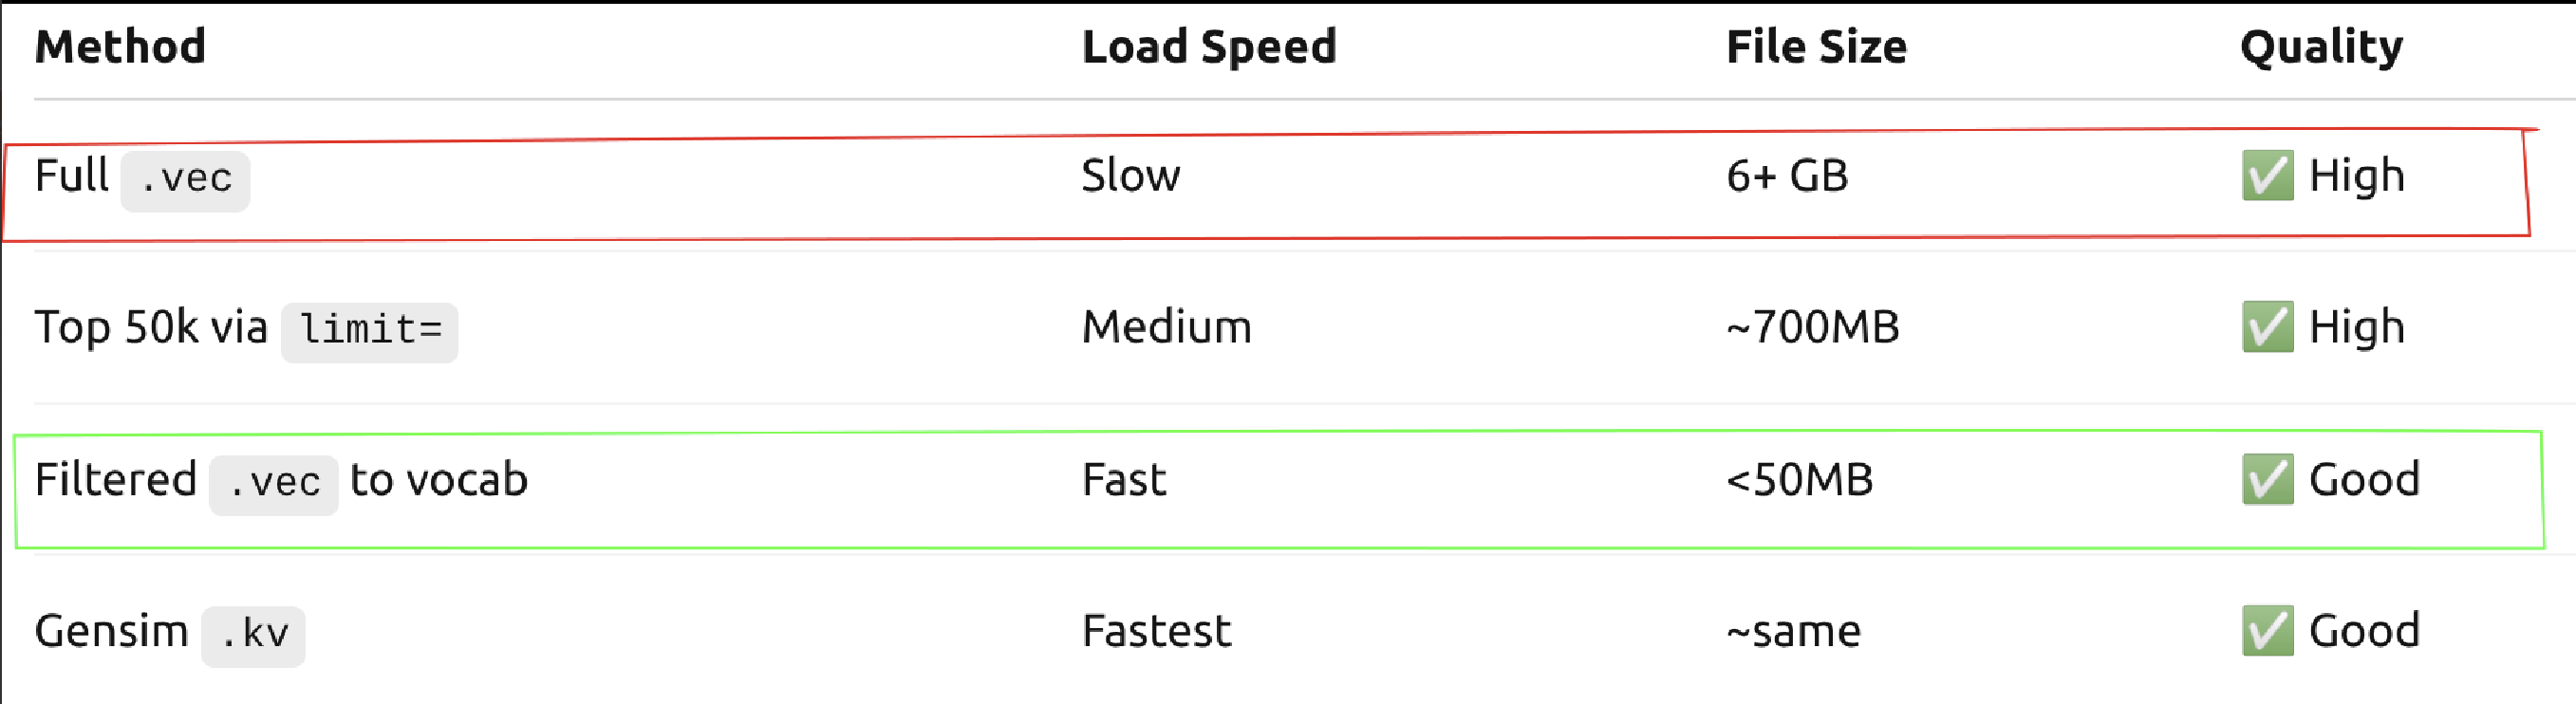

## Gensim Library KeyedVectors.load_word2vec_format()

Purpose: Loads word vectors from a file in the word2vec C format.      
Input: Takes the path to the word2vec C format file, and optionally, a binary parameter to indicate whether the file is binary or text.          
Output: Returns a KeyedVectors object containing the loaded word vectors. 

In [7]:
# Load FastText word embeddings (limit for performance)
# Download from: https://fasttext.cc/docs/en/crawl-vectors.html
# Use: 'cc.it.300.vec' in the same folder

print("Loading word vectors (this may take a minute)...")
model = KeyedVectors.load_word2vec_format("cc.it.filtered.vec", binary=False, limit=14626)
print("Model loaded.")

# Get average vector for known words
def get_user_vector(user_known_words):
    vectors = [model[word] for word in user_known_words if word in model]
    if len(vectors) == 0:
        return None
    elif len(vectors) == 1:
        return vectors[0]  # just return the single vector
    else:
        return np.mean(vectors, axis=0)

user_vector = get_user_vector(user_known_words)

Loading word vectors (this may take a minute)...
Model loaded.


In [8]:
# Generate and display recommendations with similarity
def similarity_score(word, user_vector):
    if word in model and user_vector is not None:
        return cosine_similarity([model[word]], [user_vector])[0][0]
    return 0.0

recommendations, user_pos = recommend_words(user_known_words, user_cefr_level, vocab_df, top_n=100)
recommendations = recommendations.copy()
recommendations["similarity"] = recommendations["word"].apply(lambda w: similarity_score(w, user_vector))
recommendations = recommendations.drop_duplicates(subset="word")
recommendations = recommendations.sort_values(by=["similarity", "frequency"], ascending=[False, False])
recommendations.head(5)

user_known_words: {'cibo', 'cena', 'torta', 'mangiare'}
Filtering by CEFR: ['B1', 'B2']
Most common POS among known words: n


,word,cefr_level,frequency,Pos,similarity
2511,ristorante,B1,14649.0,n,0.620415
2487,cucina,B1,19529.0,n,0.527093
2535,pesce,B1,12745.0,n,0.526550
2467,fame,B1,24920.0,n,0.478472
2516,locale,B1,14099.0,n,0.397054


# Recommender System Output 
Known words: {'cibo', 'mangiare', 'cena'}  
Target CEFR level: B1  

## Since "cibo" and "cena" are nouns, the dominant POS is "n" as the recommender output shows below.  

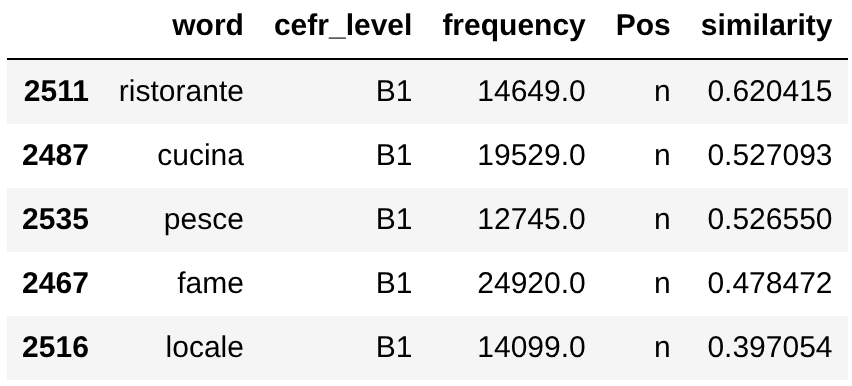

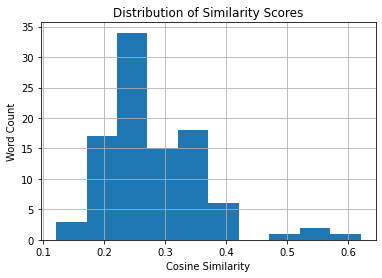

In [9]:
recommendations["similarity"].hist(bins=10)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Word Count")
plt.show()

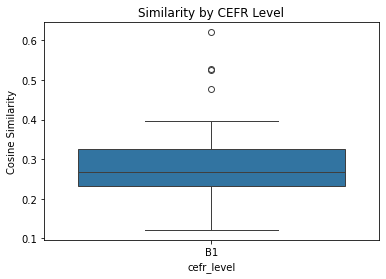

In [10]:
sns.boxplot(data=recommendations, x="cefr_level", y="similarity")
plt.title("Similarity by CEFR Level")
plt.ylabel("Cosine Similarity")
plt.show()

# Feedback Loop
User marks which words they learned from the session  
Their selections (yes/no) are logged with the features into learnability_log.json  
This growing log is used to retrain the readiness model, improving personalization

In [11]:
# Ask user: which words did you actually learn or accept?
accepted_input = input("Which words did you learn from this list? (comma-separated): ")
accepted_words = {w.strip().lower() for w in accepted_input.split(",") if w.strip()}

# Merge and save to file
all_known_words = user_known_words.union(accepted_words)
with open("known_words.json", "w") as f:
    json.dump({"known_words": sorted(list(all_known_words))}, f)

print(f"Saved updated known words list to 'known_words.json'")

Which words did you learn from this list? (comma-separated): fame
Saved updated known words list to 'known_words.json'


In [12]:
print(f"Accepted words: {accepted_words}")
print(f"Words in recommendations: {list(recommendations['word'])}")

Accepted words: {'fame'}
Words in recommendations: ['ristorante', 'cucina', 'pesce', 'fame', 'locale', 'bagno', 'cane', 'caccia', 'denaro', 'matrimonio', 'sacco', 'latte', 'sesso', 'solito', 'bar', 'marito', 'droga', 'spiaggia', 'portata', 'mamma', 'fretta', 'tanto', 'sorpresa', 'volo', 'freddo', 'fidanzato', 'cosa', 'biglietto', 'meglio', 'amico', 'natale', 'nave', 'letto', 'aereo', 'bordo', 'tesoro', 'villaggio', 'poco', 'cervello', 'cavallo', 'rumore', 'finale', 'paziente', 'ponte', 'era', 'santo', 'nemico', 'albero', 'passato', 'pianeta', 'signora', 'segreto', 'specie', 'permesso', 'privato', 'meno', 'uno', 'bomba', 'sorella', 'palla', 'turno', 'treno', 'verso', 'attimo', 'testimone', 'papa', 'verde', 'onore', 'camion', 'luna', 'pista', 'vuoto', 'soldato', 'fianco', 'presente', 'costa', 'ultimo', 'vicino', 'angolo', 'razza', 'destino', 'inglese', 'okay', 'morto', 'eroe', 'mandato', 'signorina', 'minaccia', 'traduzione', 'vento', 'alto', 'gamba', 'altezza', 'test', 'radio', 'revisio

# Readiness Scoring (Machine Learning)

## Features for each word:
    Semantic similarity
    Frequency
    POS match
    CEFR gap (word level - user level)

These are passed to a trained logistic regression model to get a readiness score:
Probability that the learner is ready to learn the word  

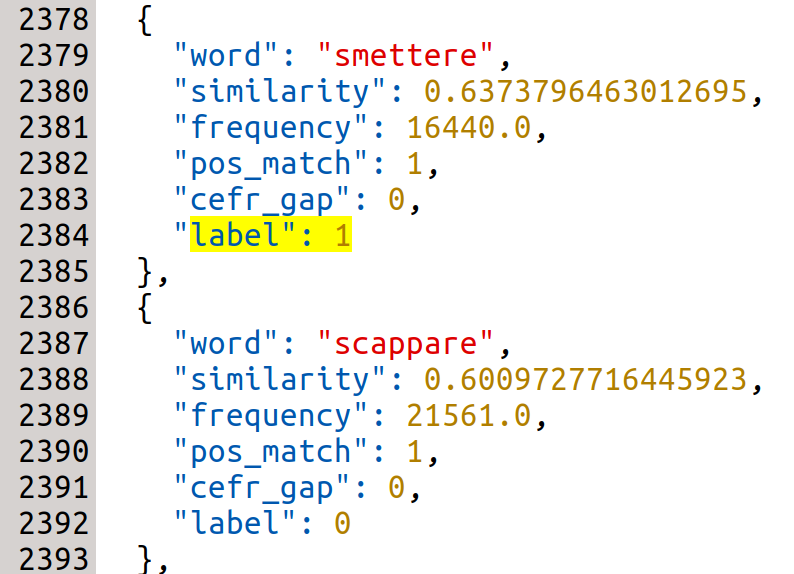

In [13]:
#Log Interaction as Feature Rows

cefr_order = ["A1", "A2", "B1", "B2", "C1", "C2"]

log_rows = []

for _, row in recommendations.iterrows():
    label = 1 if row["word"].lower() in accepted_words else 0
    cefr_gap = cefr_order.index(row["cefr_level"]) - cefr_order.index(user_cefr_level)
    pos_match = int(row["Pos"] == user_pos)

    log_rows.append({
        "word": row["word"],
        "similarity": row["similarity"],
        "frequency": row["frequency"],
        "pos_match": pos_match,
        "cefr_gap": cefr_gap,
        "label": label
    })

log_file = "learnability_log.json"
if os.path.exists(log_file):
    with open(log_file, "r") as f:
        logs = json.load(f)
else:
    logs = []

# Remove duplicates from this session (same word + features)
log_rows = [dict(t) for t in {tuple(row.items()) for row in log_rows}]

# Optional: filter out rows already in existing log
logs_set = {tuple(row.items()) for row in logs}
log_rows = [row for row in log_rows if tuple(row.items()) not in logs_set]

logs.extend(log_rows)

with open(log_file, "w") as f:
    json.dump(logs, f, indent=2)

print(f"✅ Logged {len(log_rows)} entries to learnability_log.json")

with open("learnability_log.json", "r") as f:
    latest = json.load(f)

print(f"🔎 Total entries in log: {len(latest)}")

✅ Logged 1 entries to learnability_log.json
🔎 Total entries in log: 3114


# 🤖 Machine Learning

Model: LogisticRegression from sklearn  
Training Data: Logged session data with features and binary labels (ready = 1, not ready = 0)  
Target: Predict whether the user is ready to learn a given word  

Training the Readiness Model is handled by train_word_readiness_model.ipynb also in the repository.

## Ranking & Display
Words are ranked by:  

    readiness score (from ML model)  
    Semantic similarity (secondary)  
    Frequency (tie-breaker)  
    Top results are shown to the user  
    
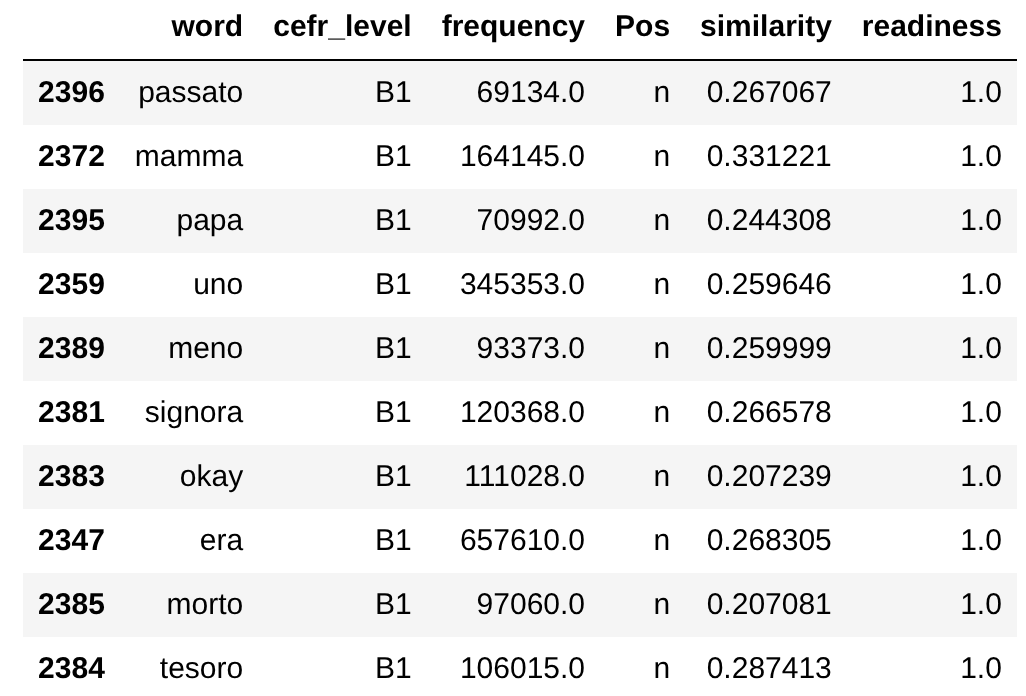    

In [14]:
# Load and apply the trained readiness model
readiness_model = joblib.load("word_readiness_model.pkl")

cefr_order = ["A1", "A2", "B1", "B2", "C1", "C2"]
def predict_readiness(row):
    cefr_gap = cefr_order.index(row["cefr_level"]) - cefr_order.index(user_cefr_level)
    pos_match = int(row["Pos"] == user_pos)
    features = pd.DataFrame([[
    row["similarity"], row["frequency"], pos_match, cefr_gap]], columns=["similarity", "frequency", "pos_match", "cefr_gap"])
    return readiness_model.predict_proba(features)[0][1]

recommendations["readiness"] = recommendations.apply(predict_readiness, axis=1)
recommendations = recommendations.sort_values(by="readiness", ascending=False)
recommendations.head(10)


,word,cefr_level,frequency,Pos,similarity,readiness
2396,passato,B1,69134.0,n,0.267067,1.0
2372,mamma,B1,164145.0,n,0.331221,1.0
2395,papa,B1,70992.0,n,0.244308,1.0
2359,uno,B1,345353.0,n,0.259646,1.0
2389,meno,B1,93373.0,n,0.259999,1.0
2381,signora,B1,120368.0,n,0.266578,1.0
2383,okay,B1,111028.0,n,0.207239,1.0
2347,era,B1,657610.0,n,0.268305,1.0
2385,morto,B1,97060.0,n,0.207081,1.0
2384,tesoro,B1,106015.0,n,0.287413,1.0


# 📌 Benefits
Personalized learning path  
Mix of linguistic structure (CEFR, POS) and meaning (similarity)   
Grows smarter with user feedback  
Ideal for intermediate learners aiming for vocab expansion